# Data_preparation

### import all relevant libraries

* install haversine ($ pip install haversine ; https://pypi.org/project/haversine/ )


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from haversine import haversine, Unit

sns.set()
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")




### define readin functions:

In [12]:
def trip_data_readin (city):
    trip_data = pd.read_csv("Project_Data/Trip_Data/"+city+".csv", encoding = "ISO-8859-1")
    trip_data = trip_data_data_prep(trip_data)
    trip_data = merge_trip_data_with_weather_data(trip_data, city)
    return trip_data


def trip_data_data_prep(trip_data):
    trip_data["datetime_start"] = pd.to_datetime(trip_data['day'] + ' ' + trip_data['time'])
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_end"] = trip_data["datetime_start"] + trip_data["trip_duration"]
    trip_data["weekday"] = pd.to_datetime(trip_data["datetime_start"]).dt.weekday
    trip_data["month"] = trip_data["datetime_start"].dt.month
    trip_data["hour" ] = trip_data["datetime_start"].dt.hour
    trip_data["week" ] = trip_data["datetime_start"].dt.isocalendar().week
    
    trip_data = estimate_fleetsize(trip_data,"week")
    trip_data = estimate_fleetsize(trip_data,"day")
    trip_data = estimate_fleetsize(trip_data,"month")
    
    trip_data = distance_between_coordinates (trip_data)    
    trip_data = cleaning(trip_data)
    return trip_data

def distance_between_coordinates (trip_data):
    trip_data["distance"] = trip_data.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(row["dest_lat"], row["dest_lng"]),Unit.KILOMETERS), axis=1) 
    return trip_data

def estimate_fleetsize(trip_data, time_resolution):
    temp = pd.DataFrame(trip_data.groupby(time_resolution)["b_number"].nunique())
    temp = temp.rename(columns={"b_number": "fleetsize_"+time_resolution+"ly"})
    trip_data =pd.merge(trip_data, temp , on=time_resolution, how='left')
    return trip_data




def merge_trip_data_with_weather_data (trip_data, city):
    trip_data.set_index(pd.DatetimeIndex(trip_data["datetime_start"]),inplace=True)
    weather = read_DWD_data (city)
    trip_data["rounded_time_hourly"] = trip_data["datetime_start"].dt.round("H")
    combined = pd.merge(trip_data, weather , on="rounded_time_hourly", how='left')
    combined["wind"] = combined['wind'].fillna(method="ffill")
    combined["rain"] = combined['rain'].fillna(method="ffill")
    combined["temp"] = combined['temp'].fillna(method="ffill")
    return combined


def read_DWD_data (city):
    
    temp_data = pd.read_csv("Project_Data/Weather_Data/"+city+"/"+"data_TT_TU_MN009.csv", encoding = "ISO-8859-1")
    temp_data =temp_data.rename(columns={"Zeitstempel": "rounded_time_hourly"})
    temp_data.set_index((pd.to_datetime(temp_data['rounded_time_hourly'].astype(str), format='%Y%m%d%H%M') ),inplace=True)
    temp_data=temp_data.drop(['Produkt_Code', 'SDO_ID','SDO_ID','Qualitaet_Niveau','Qualitaet_Byte','rounded_time_hourly'], axis=1)
    temp_data.columns = ['temp']


    wind_data = pd.read_csv("Project_Data/Weather_Data/"+city+"/"+"data_F_MN003.csv", encoding = "ISO-8859-1")
    wind_data =wind_data.rename(columns={"Zeitstempel": "rounded_time_hourly"})
    wind_data.set_index((pd.to_datetime(wind_data['rounded_time_hourly'].astype(str), format='%Y%m%d%H%M') ),inplace=True)
    wind_data = wind_data.drop(['Produkt_Code', 'SDO_ID','SDO_ID','Qualitaet_Niveau','Qualitaet_Byte','rounded_time_hourly'], axis=1)
    wind_data.columns = ['wind']

    
    rain_data = pd.read_csv("Project_Data/Weather_Data/"+city+"/"+"data_R1_MN008.csv", encoding = "ISO-8859-1")
    rain_data =rain_data.rename(columns={"Zeitstempel": "rounded_time_hourly"})
    rain_data.set_index((pd.to_datetime(rain_data['rounded_time_hourly'].astype(str), format='%Y%m%d%H%M') ),inplace=True)
    rain_data = rain_data.drop(['Produkt_Code', 'SDO_ID','SDO_ID','Qualitaet_Niveau','Qualitaet_Byte','rounded_time_hourly'], axis=1)
    rain_data.columns = ['rain']
    
    
    weather = pd.merge(temp_data, wind_data , on="rounded_time_hourly", how='left')
    weather = pd.merge(weather, rain_data , on="rounded_time_hourly", how='left')
    return weather


# Data Cleaning

In [13]:
# deleting trips with avg. speed over 25km/h
def cleaning (trip_data):
    trip_data["trip_duration_hours"] = trip_data["trip_duration"].dt.total_seconds()/3600
    trip_data["avg_speed"] = trip_data["distance"]/trip_data["trip_duration_hours"]
    trip_data.drop(trip_data[trip_data["avg_speed"]>25].index, axis=0, inplace=True)
    return trip_data





## Create combined Dataset


In [14]:
def export (city_name):
    data_set = trip_data_readin(city_name)
    data_set.to_csv("Project_Data/Combined_Data/"+city_name+".csv") 



In [15]:
# execute only in case of new data updates #

# export ("duesseldorf")
# export ("bremen")


In [16]:
data_set = trip_data_readin("bremen") 



In [17]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57894 entries, 0 to 57893
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   day                  57894 non-null  object         
 1   time                 57894 non-null  object         
 2   b_number             57894 non-null  int64          
 3   city                 57894 non-null  object         
 4   trip_duration        57894 non-null  timedelta64[ns]
 5   orig_lat             57894 non-null  float64        
 6   orig_lng             57894 non-null  float64        
 7   dest_lat             57894 non-null  float64        
 8   dest_lng             57894 non-null  float64        
 9   datetime_start       57894 non-null  datetime64[ns] 
 10  datetime_end         57894 non-null  datetime64[ns] 
 11  weekday              57894 non-null  int64          
 12  month                57894 non-null  int64          
 13  hour            

# Fleet Size:

The following section deals with the calculation of the fleet size of the respective cities, which will be used as a basis for the calculation of other key performance indices (KPI). Since the fleet size is not covered by the data, we approximate the fleet size based on the number of bikes in a given period. To assess this period, the following fleet sizes were first calculated:

1. **Fleet size per week:** Assuming that a bike that does not appear in the list of trips for a week is no longer part of the fleet.
2. **Fleet size per month:** Assuming that the fleet only includes bikes that have been driven within one month.
3. **Fleet size per day:** Based on the assumption that bicycles that have not been used for a day are no longer part of the fleet.

### Read data

Reading the data per city:

In [18]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])


    return trip_data

### Calculate fleet sizes

Calculate and plot fleet sizes based on time resolution and fleet data:

In [22]:
def get_daily_fleet_size (fleet, timeresolution):
    fleet["day"] = pd.to_datetime(fleet["day"],format='%Y%m%d')
    fleet["week"] = fleet["day"].dt.isocalendar().week


    first = fleet["day"].iloc[0]
    last = fleet["day"].iloc[-1]
    i = (last-first)/np.timedelta64(1,'D')
    test = first + pd.to_timedelta(np.arange(int(i)+1), 'D')
    plot = pd.DataFrame(test)
    plot = plot.set_index(test)
    plot = pd.DataFrame((fleet.groupby(timeresolution)["b_number"].nunique()))
    return plot

In [23]:
def plot_daily_fleet_size(fleets, cities, timeresolution): 
    
    fig,ax = plt.subplots(figsize=(15,5), dpi= 80)
    
    daily_fleet_size = get_daily_fleet_size(fleets[0],timeresolution)
    ax.plot(daily_fleet_size.index, daily_fleet_size["b_number"], color="green")
    mean_fleet_size = round(daily_fleet_size["b_number"].mean(),2)
    print("Average fleet size for " + cities[0] + " per " + timeresolution + ": " + str(mean_fleet_size))
    
    daily_fleet_size = get_daily_fleet_size(fleets[1],timeresolution)
    ax.plot(daily_fleet_size.index, daily_fleet_size["b_number"], color="blue")
    mean_fleet_size = round(daily_fleet_size["b_number"].mean(),2)
    print("Average fleet size for " + cities[1] + " per " + timeresolution + ": " + str(mean_fleet_size))
    
    ax.set_xlabel(timeresolution+"s")
    ax.set_ylabel("Number of bikes per "+ timeresolution)
    ax.set_title("Number of bikes per "+timeresolution )
    ax.legend(["Duesseldorf", "Bremen"]);

    plt.savefig("Project_Data/Graphics"+timeresolution+".pdf")
    plt.show()

### Visualize calculated fleet sizes per city

Average fleet size for Duesseldorf per day: 69.89
Average fleet size for Bremen per day: 150.03


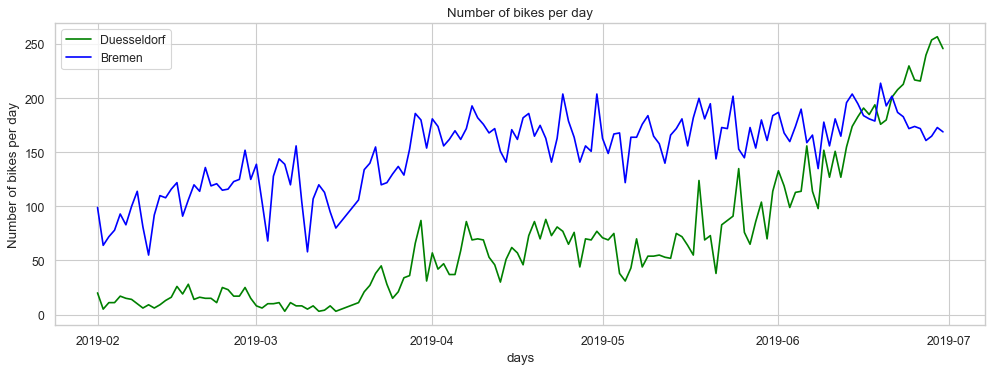

Average fleet size for Duesseldorf per week: 194.59
Average fleet size for Bremen per week: 283.95


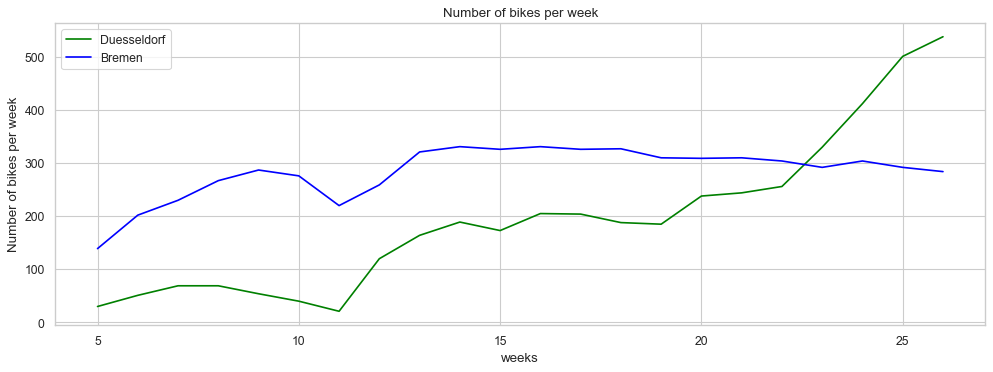

Average fleet size for Duesseldorf per month: 326.6
Average fleet size for Bremen per month: 366.8


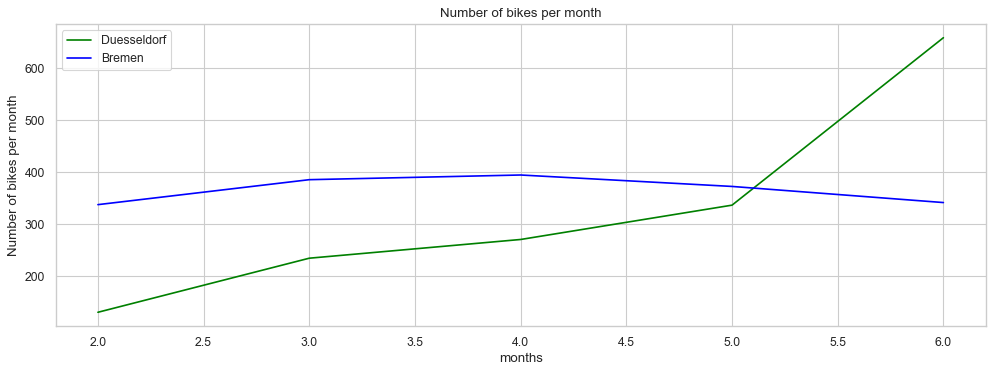

In [24]:
fleet_dus = read_data("duesseldorf")
fleet_bre = read_data("bremen")

cities = ['Duesseldorf','Bremen']
fleets = [fleet_dus, fleet_bre]

plot_daily_fleet_size(fleets, cities, "day")
plot_daily_fleet_size(fleets, cities, "week")
plot_daily_fleet_size(fleets, cities, "month")

Based on the previous visualizations, all following calculations are based on the assumption that a bike that has not been used for more than one week is no longer part of the fleet. A daily calculation of the fleet size seems to be too sensitive to reflect the reality due to the high fluctuations in the key figure. A monthly calculation seems too rough to be used as a basis for calculating other key figures.
Possible reasons for the removal of bikes from the fleet could be theft or longer repairs of the bikes.